## Análisis de datos - Clase 3
---

## Taller práctico parte 2 - preparación completa de un dataset para entrenamiento de modelos de IA
---


Vamos a realizar una actividad con un dataset con los datos del Servicio Meteorológico Nacional Argentino que utilizamos en el taller práctico 1.

A modo de repaso, el dataset contiene estadísticas climáticas normales (período 1991-2020) y temperaturas máximas y mínimas registradas durante el último año (365 días).

Fuente: https://www.smn.gob.ar/descarga-de-datos

En esta segunda parte del taller, vamos a preparar el dataset para que pueda ser utilizado en el entrenamiento de modelos de IA para resolver un determinado problema de ML.


Resumen de descubrimientos del taller 1:

**Variables**:

* estación, provincia, latitud, longitud, altitud, número y NroOACI (estos dos últimos identifican las estaciones)
* mes
* temperatura media, máxima y mínima
* humedad relativa
* velocidad del viento
* nubosidad total (en meteorología, la nubosidad se mide en octas (0, despejado - 8 completamente cubierto), que representan la fracción del cielo cubierta por nubes)
* precipitación
* frecuencia de días con precipitación superior a 0,1 mm.

**Dimensiones**: (1176, 16)

**Tipos de datos**:
* Variables numéricas:  'altura', 'LAT_decimal','LON_decimal', 'prec_sup_1mm', 'humedad', 'nubosidad', 'prec_mm', 'temp', 'temp_max', 'temp_min', 'viento'
* Variables categóricas: 'estacion', 'provincia','numero', 'NroOACI', 'mes_txt'

**Generales**:
* No hay variables ordinales.
* Hay 98 observaciones (filas) para cada mes del año.
* Hay más estaciones en la provincia de Buenos Aires que en cualquier otra provincia.

**Datos faltantes (resumen)**:
| Variable       | Nro Faltantes | % Faltantes | Causa | Comentarios |
|----------------|---------------|-------------|-------|-------------|
| viento         | 468           | 39.80%      | Inconcluso  | En este caso podemos considerarla MAR para el ejercicio, pero requiere investigación. Potencialmente no es un faltante sino que ciertas estaciones (94) no miden viento, o no lo reportan. |
| prec_sup_1mm   | 115           | 9.78%       | MAR   | prec_mm y prec_sum_1mm se mueven juntas.Asumimos MAR, pero requiere investigación. Solo falta para las bases de la Antártida y Santa Cruz.                |
| prec_mm        | 115           | 9.78%       | MAR   | prec_mm y prec_sum_1mm se mueven juntas. Asumimos MAR, pero requiere investigación. Solo falta para las bases de la Antártida y Santa Cruz |
| humedad        | 66            | 5.61%       | MAR   | Parecen estar asociados a ciertas estaciones y a cierta época del año.|
| temp_min       | 52            | 4.42%       | MAR   |Parecen ocurrir solo en ciertas estaciones meteorológicas |
| NroOACI        | 36            | 3.06%       | No son faltantes  | Corresponden a 3 estaciones sin OACI asignado|
| provincia      | 24            | 2.04%       | N/A  |Se pueden completar (se tiene el nombre de la estación meteorológica) |
| altura         | 24            | 2.04%       | N/A |Se pueden completar (se tiene el nombre de la estación meteorológica) |
| numero         | 24            | 2.04%       | N/A |Se pueden completar (se tiene el nombre de la estación meteorológica) |
| LAT_decimal    | 24            | 2.04%       | N/A |Se pueden completar (se tiene el nombre de la estación meteorológica) |
| LON_decimal    | 24            | 2.04%       | N/A |Se pueden completar (se tiene el nombre de la estación meteorológica) |
| temp_max       | 18            | 1.53%       | MAR  |Asociados a ciertas estaciones meteorológicas|
| nubosidad      | 10            | 0.85%       | MAR  |Asociados a ciertas estaciones meteorológicas y meses del año|
| temp           | 9             | 0.77%       | MAR  |Asociados a ciertas estaciones meteorológicas y meses del año|

**Outliers**:

1) Estaciones meteorológicas

- Los valores atípicos en altura no son errores. Corresponden a estaciones meteorológicas localizadas en zonas de cordillera o precordillera.
- Los valores de latitud y longitud extremadamente alejadas del resto también se consideran datos válidos ya que corresponden a estaciones de la Antártida.

2) Temperaturas

- Las temperaturas extremas negativas corresponden a estaciones meteorológicas antárticas, por lo que consideran válidas.

3) Nubosidad

- La variable nubosidad muestra valores atípicos mayores a 5,5. Estos números representan un cielo que en promedio está mayormente nublado a completamente cubierto. Se observa para estaciones de la Antártida, lo que hace pensar que en este caso también son valores correctos.

4) Otras variables

- La cantidad de valores atípicos es despreciable.

En general en todo el set de datos, los valores atípicos se presentan principalmente en las bases antárticas y en todos los casos se puede concluir que son valores legítimos.


In [1432]:
import pandas as pd
import numpy as np
from datetime import timedelta
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from statsmodels.imputation import mice
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest,SelectFpr, chi2, f_classif, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

---
### 1. Importar los datos
---

In [1433]:
smn_historico = pd.read_csv('../datasets/smn/smn_historico.csv', na_values=['S/D'])

In [1434]:
smn_historico.shape

(1176, 16)

In [1435]:
# Visualizar primeras filas
smn_historico.head()

,estacion,provincia,altura,numero,NroOACI,LAT_decimal,LON_decimal,mes_txt,prec_sup_1mm,humedad,nubosidad,prec_mm,temp,temp_max,temp_min,viento
0,AEROPARQUE AERO,CAPITAL FEDERAL,6.0,87582.0,SABE,-34.55,-58.416667,Ene,6.7,67.0,3.1,117.5,24.5,28.4,20.8,16.8
1,AEROPARQUE AERO,CAPITAL FEDERAL,6.0,87582.0,SABE,-34.55,-58.416667,Feb,6.0,69.8,3.2,112.3,23.7,27.3,20.2,15.8
2,AEROPARQUE AERO,CAPITAL FEDERAL,6.0,87582.0,SABE,-34.55,-58.416667,Mar,5.9,71.3,3.1,111.8,22.0,25.5,18.8,14.9
3,AEROPARQUE AERO,CAPITAL FEDERAL,6.0,87582.0,SABE,-34.55,-58.416667,Abr,6.6,73.6,3.5,108.3,18.5,22.0,15.3,13.9
4,AEROPARQUE AERO,CAPITAL FEDERAL,6.0,87582.0,SABE,-34.55,-58.416667,May,5.0,76.4,4.0,83.3,15.2,18.4,12.3,12.9


---
### 2. EDA y exploración: ver notebook del taller práctico 1 y resumen en la parte superior de esta notebook
---

In [1436]:
# Completamos datos faltantes que se podían sacar de Internet (https://heladas.agro.uba.ar/estaciones.htm)
smn_historico.loc[smn_historico['estacion'] == 'EL TREBOL', 'provincia'] = 'SANTA FE'
smn_historico.loc[smn_historico['estacion'] == 'EL TREBOL', 'LAT_decimal'] = -32.202
smn_historico.loc[smn_historico['estacion'] == 'EL TREBOL', 'LON_decimal'] = -61.7
smn_historico.loc[smn_historico['estacion'] == 'EL TREBOL', 'altura'] = 96
smn_historico.loc[smn_historico['estacion'] == 'CORONEL PRINGLES AERO', 'provincia'] = 'BUENOS AIRES'
smn_historico.loc[smn_historico['estacion'] == 'CORONEL PRINGLES AERO', 'LAT_decimal'] = -38.02
smn_historico.loc[smn_historico['estacion'] == 'CORONEL PRINGLES AERO', 'LON_decimal'] = -61.33
smn_historico.loc[smn_historico['estacion'] == 'CORONEL PRINGLES AERO', 'altura'] = 247


In [1437]:
# Función auxiliar para calcular faltantes
def calcular_faltantes(df):
    faltantes = df.isna().sum()

    # Calculamos porcentaje de valores faltantes
    total_filas = df.shape[0]
    faltantes_df = faltantes.to_frame(name='faltantes')
    faltantes_df['porcentaje'] = ((faltantes_df['faltantes'] / total_filas) * 100).round(2)
    faltantes_df = faltantes_df.sort_values(by='faltantes', ascending=False)

    # Mostramos solo las que tienen valores faltantes
    return faltantes_df[faltantes_df['faltantes'] > 0]

In [1438]:
print("Faltantes en smn_historico:")
calcular_faltantes(smn_historico)

Faltantes en smn_historico:


,faltantes,porcentaje
viento,468,39.80
prec_sup_1mm,115,9.78
prec_mm,115,9.78
humedad,66,5.61
temp_min,52,4.42
NroOACI,36,3.06
numero,24,2.04
temp_max,18,1.53
nubosidad,10,0.85
temp,9,0.77


---
#### 3. Problema de ML propuesto: 

#### Predecir la temperatura promedio mensual (problema de regresión), dada una determinada Latitud, Longitud, altura y otros datos climáticos.
---

---
### 4. Split del dataset
---
Consideraciones al hacer el split:
* No puedo hacer un split aleatorio ya que potencialmente podría poner datos de la misma estación meteorológica en ambos conjuntos.
* Necesito poner toda la información de una estación en uno de los conjuntos (o train o test).
* Necesito asegurarme que tengo una distribución espacial variada en ambos sets. Por ejemplo, no debería tener todos los datos de la Patagonia solo en test (tengo que tener una representación variada de las regiones geográficas en ambos sets).
* Una solución, por ejemplo, es hacer un split stratificado por provincia.

In [1439]:
# Cuántas estaciones por provincia hay?
smn_historico.groupby('provincia')['estacion'].nunique().sort_values(ascending=False)

provincia
BUENOS AIRES       21
CORDOBA             8
ANTARTIDA           6
SANTA FE            6
SANTA CRUZ          6
RIO NEGRO           5
MENDOZA             5
MISIONES            4
JUJUY               3
SALTA               3
LA RIOJA            3
ENTRE RIOS          3
CORRIENTES          3
CHUBUT              3
LA PAMPA            2
FORMOSA             2
CHACO               2
SAN JUAN            2
SAN LUIS            2
CATAMARCA           2
CAPITAL FEDERAL     2
TIERRA DEL FUEG     2
NEUQUEN             1
SANTIAGO DEL ES     1
TUCUMAN             1
Name: estacion, dtype: int64

#### Split stratificado con sklearn
Paso intermedio: armo un mini-dataframe de estaciones con su provincia.

In [1440]:
# Armo una lista de estaciones únicas por provincia
estacion_provincia = smn_historico[['estacion', 'provincia']].drop_duplicates()

# Cuento las estaciones en cada provincia
provincia_counts = estacion_provincia.groupby('provincia').size()

# Identifico y separo las provincias con menos de 1 estación
# Para usar el método stratfy de abajo debo tener al menos 2 estaciones por provincia
provincis_multi_estacion = provincia_counts[provincia_counts > 1].index
provincias_unica_estacion = provincia_counts[provincia_counts == 1].index

# Split solo de las provincias con más de 1 estación
multi_estacion = estacion_provincia[estacion_provincia['provincia'].isin(provincis_multi_estacion)]
estaciones_train, estaciones_test = train_test_split(
    multi_estacion, 
    test_size=0.30, 
    stratify=multi_estacion['provincia'],
    random_state=42
)

# Las provincias de una sola estación las agrego a train
unica_estacion = estacion_provincia[estacion_provincia['provincia'].isin(provincias_unica_estacion)]
estaciones_train = pd.concat([estaciones_train, unica_estacion], ignore_index=True)

print(f"Train: {len(estaciones_train)} estaciones")
print(f"Test: {len(estaciones_test)} estaciones")


Train: 69 estaciones
Test: 29 estaciones


In [1441]:
print(f"\nProvincias en Train:\n{estaciones_train['provincia'].value_counts()}")


Provincias en Train:
provincia
BUENOS AIRES       15
CORDOBA             6
ANTARTIDA           4
RIO NEGRO           4
SANTA CRUZ          4
MENDOZA             4
SANTA FE            4
MISIONES            3
CHUBUT              2
LA RIOJA            2
ENTRE RIOS          2
JUJUY               2
TIERRA DEL FUEG     2
CATAMARCA           2
SALTA               2
CORRIENTES          2
SAN JUAN            1
LA PAMPA            1
CAPITAL FEDERAL     1
SAN LUIS            1
CHACO               1
FORMOSA             1
NEUQUEN             1
SANTIAGO DEL ES     1
TUCUMAN             1
Name: count, dtype: int64


In [1442]:
print(f"\nProvincias en Test:\n{estaciones_test['provincia'].value_counts()}")


Provincias en Test:
provincia
BUENOS AIRES       6
SANTA CRUZ         2
ANTARTIDA          2
SANTA FE           2
CORDOBA            2
LA PAMPA           1
CORRIENTES         1
CAPITAL FEDERAL    1
ENTRE RIOS         1
MISIONES           1
CHACO              1
SAN LUIS           1
FORMOSA            1
MENDOZA            1
JUJUY              1
CHUBUT             1
SAN JUAN           1
LA RIOJA           1
RIO NEGRO          1
SALTA              1
Name: count, dtype: int64


Ahora separo en dos conjuntos en base al split stratificado que hice antes:

In [1443]:
# Obtengo una lista de estaciones en cada set
train_lista_estaciones = estaciones_train['estacion'].tolist()
test_lista_estaciones = estaciones_test['estacion'].tolist()

# Split del dataset original
df_train = smn_historico[smn_historico['estacion'].isin(train_lista_estaciones)]
df_test = smn_historico[smn_historico['estacion'].isin(test_lista_estaciones)]

print(f"Dataset de Train: {df_train.shape[0]} filas, {df_train['estacion'].nunique()} estaciones")
print(f"Dataset de Test: {df_test.shape[0]} filas, {df_test['estacion'].nunique()} estaciones")

# Verifco que el split quedó bien y no hay superposición
assert len(set(train_lista_estaciones) & set(test_lista_estaciones)) == 0, "Ojo, hay superposición de estaciones entre train y test"
print("\nVerificación: No se encontró superposición de estaciones entre train y test")


Dataset de Train: 828 filas, 69 estaciones
Dataset de Test: 348 filas, 29 estaciones

Verificación: No se encontró superposición de estaciones entre train y test


Por último, estoy en condiciones de armar X_train, X_test, y_train, y_test:

In [1444]:
# Finalmente, armamos los datasets definitivos.

# Antes que nada remuevo las filas con nulos en la variable target:
df_train = df_train[df_train['temp'].notna()]
df_test = df_test[df_test['temp'].notna()]


# Definimos los features y el target.
# Para los features, remuevo todos los datos asociados a estación meteorológica (3 features). 
# Además, remuevo la provincia, ya que tengo Lat y Long.  

features = ['LAT_decimal', 'LON_decimal', 'altura', 'mes_txt', 
                'prec_sup_1mm', 'humedad', 'nubosidad', 'prec_mm', 
                'temp_max', 'temp_min', 'viento']

# Defino para usarlos más adelante:
var_numericas = ['LAT_decimal', 'LON_decimal', 'altura', 
                'prec_sup_1mm', 'humedad', 'nubosidad', 'prec_mm', 
                'temp_max', 'temp_min', 'viento']

categoricas_baja_card = ['mes_txt']

target = 'temp'

# Datos de train
X_train = df_train[features].copy()
y_train = df_train[target].copy()

# Datos de test
X_test = df_test[features].copy()
y_test = df_test[target].copy()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (821, 11)
y_train shape: (821,)
X_test shape: (346, 11)
y_test shape: (346,)


---
### Tratamiento de outliers
---


Si bien los outliers en este dataset no son errores, es necesario tomar una decisión pensando en cómo pueden afectar el rendimiento de los modelos de ML. Posibles opciones:

* Dejarlos como están, ya que los valores atípicos se presentan principalmente en las bases antárticas y el modelo podría aprender la relación entre la dimensión espacial y la temperatura (por ejemplo un modelo como XGboost o Random Forest deberían funcionar bien). Se podría manejar como un proceso iterativo (ajustar solo si la performance no es la esperada).

* Hacer un tratamiento, es decir, aplicar por ejemplo una transformación logarítmica. La desventaja es que el modelo podría funcionar mal al momento de predecir temperaturas de las zonas más australes.

* Entrenar dos modelos distintos (dividir el problema Argentina continental-Antártida). Sin embargo, esto requeríaría conseguir más datos.

* Otros!

Decisión: optamos por la primera opción que es la más sencilla.


In [1445]:
# Poner aquí el código 

---
### Tratamiento de datos faltantes
---

In [1446]:
# Verifico que no hay faltantes en la variable for missing values in target
print(f"\nValores faltantes en y_train: {y_train.isna().sum()}")
print(f"Valores in y_test: {y_test.isna().sum()}")


Valores faltantes en y_train: 0
Valores in y_test: 0


In [1447]:
print("Faltantes en X_train:")
calcular_faltantes(X_train)

Faltantes en X_train:


,faltantes,porcentaje
viento,329,40.07
prec_sup_1mm,68,8.28
prec_mm,68,8.28
humedad,38,4.63
temp_min,35,4.26
temp_max,13,1.58
nubosidad,1,0.12


In [1448]:
print("Faltantes en X_test:")
calcular_faltantes(X_test)

Faltantes en X_test:


,faltantes,porcentaje
viento,130,37.57
prec_sup_1mm,42,12.14
prec_mm,42,12.14
humedad,19,5.49
temp_min,12,3.47


Opciones de tratamiento:

* Variable viento: MAR con % medio-alto. Se podría imputar con algún mecanismo como KNN o imputación múltiple (MICE).
* Variables prec_sup_1mm, prec_mm, humedad, temp_min, temp_max, humedad: MAR con % bajo. Se podrían realizar imputaciones simples.
* Nubosidad: 1 solo faltante. Se podría eliminar la fila.

* Decisión: Imputar todo con MICE/IterativeImputer. 
* Razonamiento: KNN requiere que todas las demás variables estén completas. Podría imputar con la mediana para la estación o la provincia, pero el problema es que no hay datos de la Antártida para imputar con un valor razonable. Habría que investigar esos datos y conseguirlos.


Los métodos de imputación iterativa requieren codificación y escalamiento de los datos. En este caso usaremos IterativeImputer de scikit-learn.

a) Codificación de la única variable categórica (mes_txt) con codificación cíclica.


In [1449]:
# Convertir nombres a números (1-12)
mes_dic = {
    'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Ago': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dic': 12
}

# Aplicar a train y test
X_train['mes_num'] = X_train['mes_txt'].map(mes_dic)
X_test['mes_num'] = X_test['mes_txt'].map(mes_dic)

# Crear los features codificados
X_train['mes_sin'] = np.sin(2 * np.pi * X_train['mes_num'] / 12)
X_train['mes_cos'] = np.cos(2 * np.pi * X_train['mes_num'] / 12)

X_test['mes_sin'] = np.sin(2 * np.pi * X_test['mes_num'] / 12)
X_test['mes_cos'] = np.cos(2 * np.pi * X_test['mes_num'] / 12)

# Dropear las columnas originales
X_train = X_train.drop(columns=['mes_txt', 'mes_num'])
X_test = X_test.drop(columns=['mes_txt', 'mes_num'])

b) Escalamiento de las variables numéricas (excepto las codificadas)

In [1450]:
scaler = StandardScaler()

# Saco mes porque ya está codificado
X_train_sin_mes = X_train[var_numericas].copy()
X_train_mes= X_train[['mes_sin', 'mes_cos']].copy()

# Lo mismo para test
X_test_sin_mes = X_test[var_numericas].copy()
X_test_mes = X_test[['mes_sin', 'mes_cos']].copy()

# Ajusto y transformo train
X_train_sin_mes_escalado = pd.DataFrame(
    scaler.fit_transform(X_train_sin_mes),
    columns=var_numericas,
    index=X_train_sin_mes.index  # Preservar el índice original
)

# Transformo test con el scaler ajustado en train
X_test_sin_mes_escalado = pd.DataFrame(
    scaler.transform(X_test_sin_mes),
    columns=var_numericas,
    index=X_test_sin_mes.index  # Preserve the original index
)

# Datasets escalados finales
X_train_escalado = pd.concat([X_train_sin_mes_escalado, X_train_mes], axis=1)
X_test_escalado = pd.concat([X_test_sin_mes_escalado, X_test_mes], axis=1)

X_train_escalado.head(10)

,LAT_decimal,LON_decimal,altura,prec_sup_1mm,humedad,nubosidad,prec_mm,temp_max,temp_min,viento,mes_sin,mes_cos
0,0.183223,0.698813,-0.701772,0.605925,-0.085151,-0.815185,0.969581,0.817739,1.502049,0.508900,5.000000e-01,8.660254e-01
1,0.183223,0.698813,-0.701772,0.333994,0.164328,-0.706175,0.868963,0.696507,1.425928,0.342591,8.660254e-01,5.000000e-01
2,0.183223,0.698813,-0.701772,0.295147,0.297977,-0.815185,0.859288,0.498129,1.248310,0.192912,1.000000e+00,6.123234e-17
3,0.183223,0.698813,-0.701772,0.567078,0.502905,-0.379143,0.791564,0.112393,0.804266,0.026603,8.660254e-01,-5.000000e-01
4,0.183223,0.698813,-0.701772,-0.054479,0.752384,0.165908,0.307820,-0.284364,0.423657,-0.139707,5.000000e-01,-8.660254e-01
5,0.183223,0.698813,-0.701772,-0.248715,0.743474,0.383929,-0.247517,-0.603974,0.055735,-0.256123,1.224647e-16,-1.000000e+00
6,0.183223,0.698813,-0.701772,-0.054479,0.672194,0.274919,-0.059825,-0.725206,-0.071134,-0.089814,-5.000000e-01,-8.660254e-01
7,0.183223,0.698813,-0.701772,-0.054479,0.502905,0.056898,-0.114004,-0.493764,0.093796,0.043234,-8.660254e-01,-5.000000e-01
8,0.183223,0.698813,-0.701772,0.139757,0.280157,-0.052112,0.100778,-0.295386,0.322162,0.475638,-1.000000e+00,-1.836970e-16
9,0.183223,0.698813,-0.701772,0.916703,0.235607,0.056898,0.721905,0.013203,0.677397,0.575424,-8.660254e-01,5.000000e-01


In [1451]:
# Ajustar en train
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_imputado = imputer.fit_transform(X_train_escalado)

# Train
X_train_imputado = pd.DataFrame(
    imputer.fit_transform(X_train_escalado),
    columns=X_train_escalado.columns,
    index=X_train_escalado.index
)

# Test
X_test_imputado = pd.DataFrame(
    imputer.transform(X_test_escalado),
    columns=X_test_escalado.columns,
    index=X_test_escalado.index
)

/Users/ari/opt/miniconda3/envs/add-env/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/ari/opt/miniconda3/envs/add-env/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [1452]:
X_train_imputado.head()

,LAT_decimal,LON_decimal,altura,prec_sup_1mm,humedad,nubosidad,prec_mm,temp_max,temp_min,viento,mes_sin,mes_cos
0,0.183223,0.698813,-0.701772,0.605925,-0.085151,-0.815185,0.969581,0.817739,1.502049,0.508900,0.500000,8.660254e-01
1,0.183223,0.698813,-0.701772,0.333994,0.164328,-0.706175,0.868963,0.696507,1.425928,0.342591,0.866025,5.000000e-01
2,0.183223,0.698813,-0.701772,0.295147,0.297977,-0.815185,0.859288,0.498129,1.248310,0.192912,1.000000,6.123234e-17
3,0.183223,0.698813,-0.701772,0.567078,0.502905,-0.379143,0.791564,0.112393,0.804266,0.026603,0.866025,-5.000000e-01
4,0.183223,0.698813,-0.701772,-0.054479,0.752384,0.165908,0.307820,-0.284364,0.423657,-0.139707,0.500000,-8.660254e-01


In [1453]:
print("Faltantes en X_train imputado con Iterative Imputer/MICE:")
calcular_faltantes(X_train_imputado)

Faltantes en X_train imputado con Iterative Imputer/MICE:


,faltantes,porcentaje


In [1454]:
# Poner aquí el código para tratar los datos faltantes

---
### Tratamiento de outliers
---


1) Estaciones meteorológicas

- Los valores atípicos en altura no son errores. De todas maneras, removimos
- Los valores de latitud y longitud extremadamente alejadas del resto también se consideran datos válidos ya que corresponden a estaciones de la Antártida.

2) Temperaturas

- Las temperaturas extremas negativas corresponden a estaciones meteorológicas antárticas, por lo que consideran válidas.

3) Nubosidad

- La variable nubosidad muestra valores atípicos mayores a 5,5. Estos números representan un cielo que en promedio está mayormente nublado a completamente cubierto. Se observa para estaciones de la Antártida, lo que hace pensar que en este caso también son valores correctos.

4) Otras variables

- La cantidad de valores atípicos es despreciable.

En general en todo el set de datos, los valores atípicos se presentan principalmente en las bases antárticas y en todos los casos se puede concluir que son valores legítimos.

In [1455]:
# Poner aquí el código 

---
### Codificación
---

Había una sola variable categórica (mes_txt) que ya fue codificada cíclicamente.

In [1456]:
## Poner aquí el código

---
### Escalamiento
---

El escalamiento ya fue realizado antes de la imputación.

In [1457]:
## Poner aquí el código

---
### Reducción de dimensionalidad: selección de features
---

a) Análisis de correlación (probamos con Kendall)

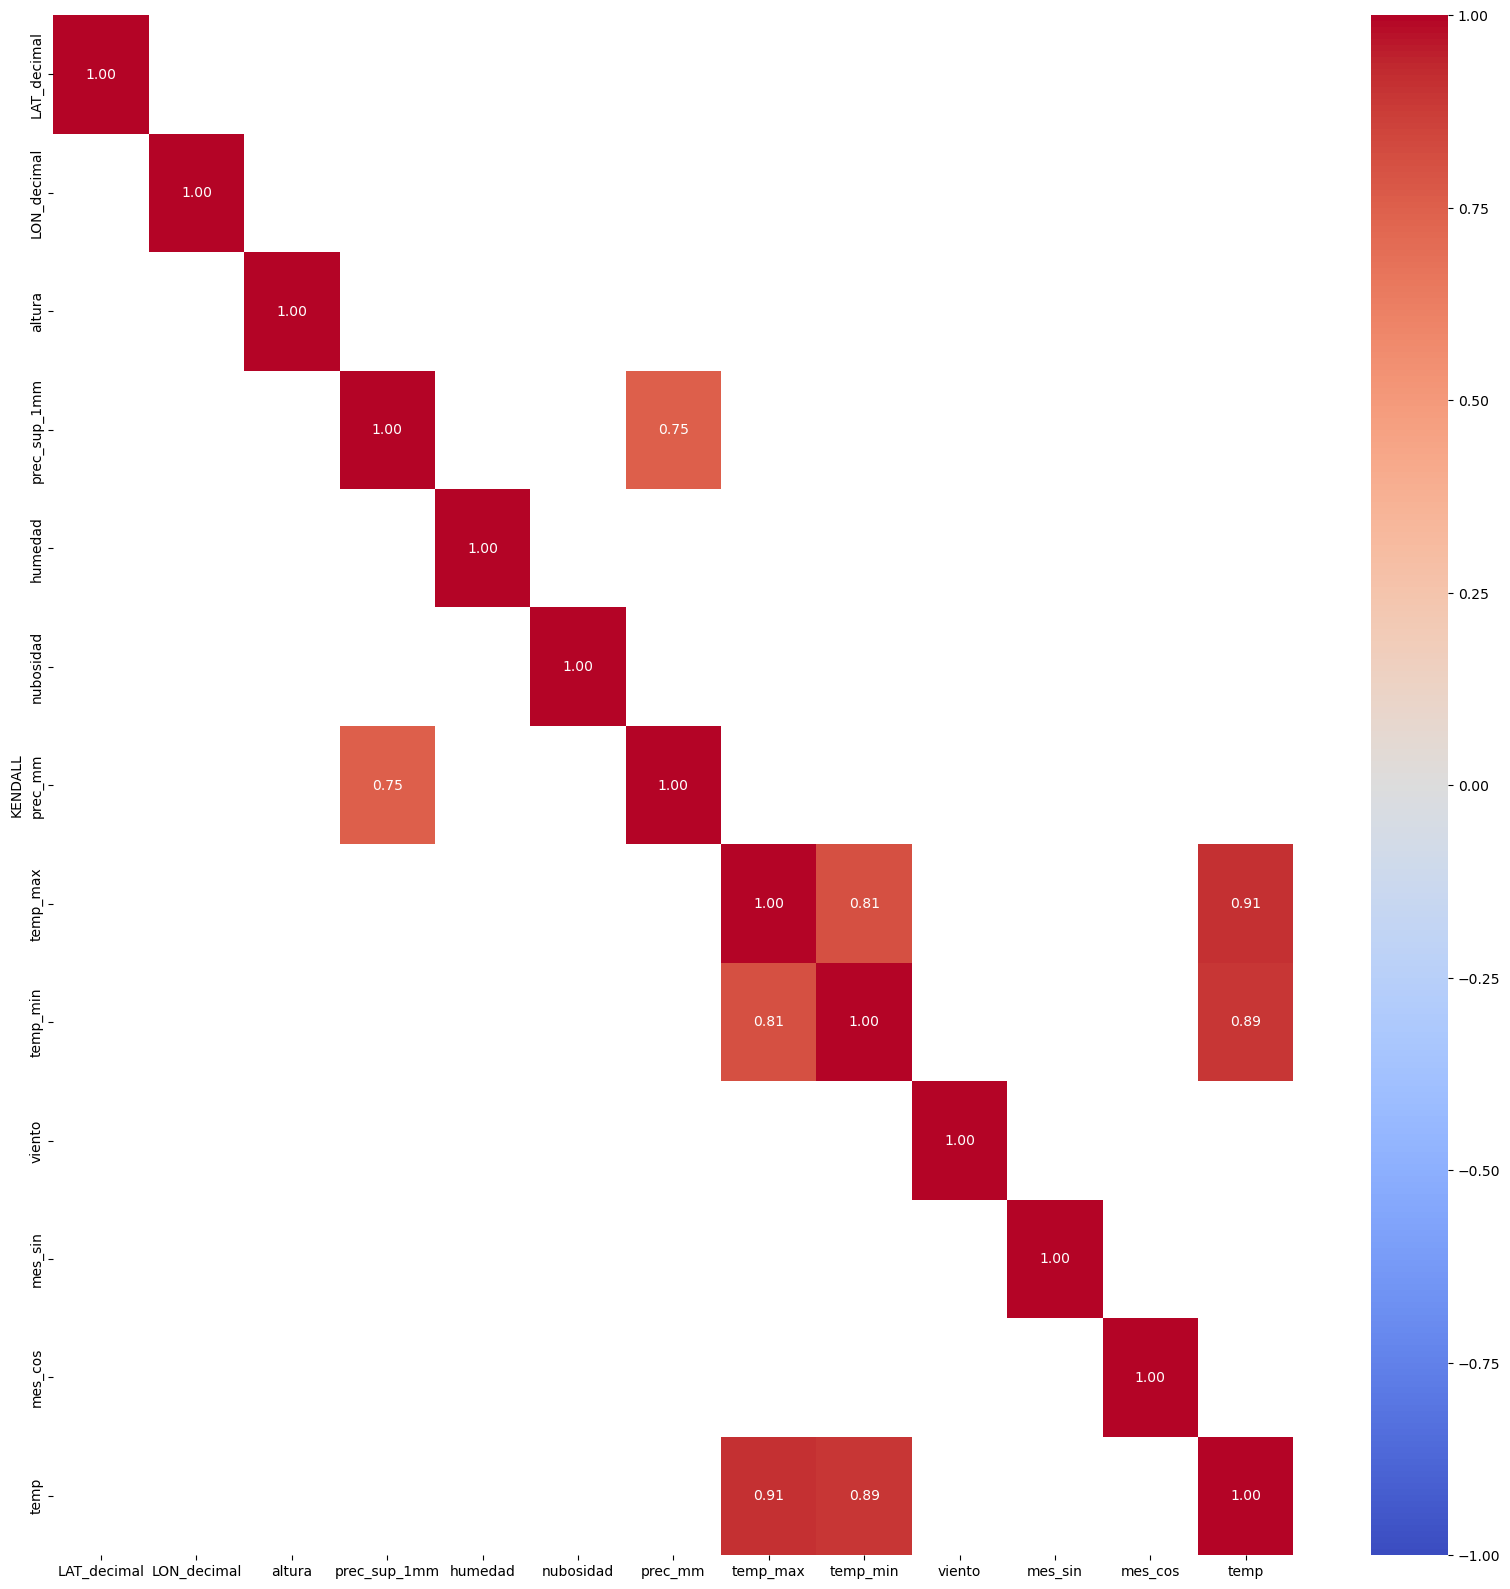

In [1458]:
# Vuelvo a armar el dataset para incluir la v.a. target y ver la corr con ella también
datos_train_corr = X_train_imputado.copy()
datos_train_corr['temp'] = y_train.copy()


umbral = 0.65
mask_for_heatmap = (datos_train_corr.corr(method='kendall').abs() < umbral)
plt.figure(figsize=(20,20))
sns.heatmap(
    datos_train_corr.corr(method='kendall'), 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm",  
    center=0, 
    vmin=-1, 
    vmax=1,
    mask=mask_for_heatmap)
plt.ylabel('KENDALL')
plt.show()

Observaciones:
* La correlación captura la relación entre prec_mm y prec_1_mm (lluvia promedio del mes y frecuencia de dias con precipitación alta), que tiene sentido.
* Además, muestra que la variable temp (target) está fuertemente relacionada con temp_min y temp_max.
* Temp_min y temp_max tienen una relación monótona creciente bastante alta entre sí (cuando una crece, la otra crece)
* Este método captura solo relaciones de temp con la precipitación y las temperaturas max y min, pero no con las coordenadas geográficas que intuitivamente sabemos que pueden aportar poder predictivo. Es importante explorar otros métodos.

b) Filtrado con Información Mutua

In [1459]:
# Información mutua (todas, fit en train, transformar ambos)
selector_mi = SelectKBest(score_func=mutual_info_regression, k=8) 
X_train_best = selector_mi.fit_transform(X_train_imputado, y_train) # todos los tipos de features

selected_indices = selector_mi.get_support()
selected_features = X_train_imputado.columns[selected_indices]
scores = selector_mi.scores_[selected_indices]
print("\nCaracterísticas seleccionadas (Inf. mutua):")
for feature, score in zip(selected_features, scores):
    print(f"{feature}: {score:.4f}")

X_test_best = selector_mi.transform(X_test_imputado)


Características seleccionadas (Inf. mutua):
LAT_decimal: 0.4736
prec_sup_1mm: 0.3206
humedad: 0.2462
nubosidad: 0.3261
prec_mm: 0.3768
temp_max: 2.0414
temp_min: 1.8282
mes_cos: 0.2458


A diferencia de la correlación, la IM sí captura el aporte de otras variables, como por ejemplo la Latitud.

In [1460]:
## Poner aquí el código

---
### Reducción de dimensionalidad: extracción de features
---

In [1461]:
## Poner aquí el código

In [1462]:
# Hago el análisis de los componentes principales (PCA)
pca = PCA(n_components=8)

X_train_pca = pca.fit_transform(X_train_imputado)
X_test_pca = pca.transform(X_test_imputado)

In [1463]:
# varianza explicada por cada componente
explained_var = pca.explained_variance_ratio_

# varianza acumulada
cumulative_var = np.cumsum(explained_var)

n_components = len(explained_var)
componentes = np.arange(1, n_components + 1)

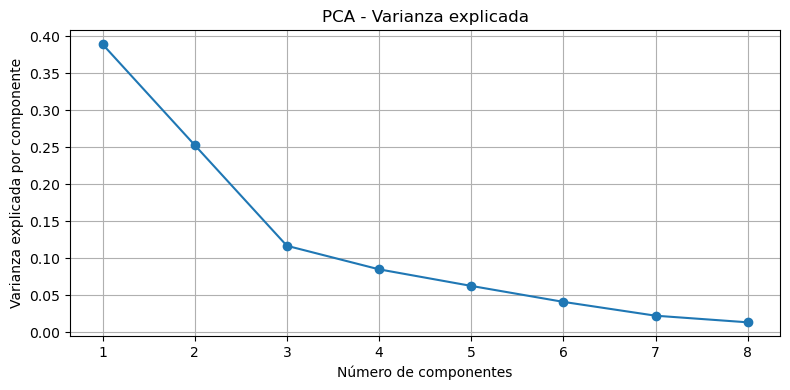

Varianza explicada por cada componente:
[0.38939187 0.25314499 0.11712986 0.08530895 0.0629238  0.04134642
 0.02268229 0.01374147]


In [1464]:
# varianza explicada por cada componente
plt.figure(figsize=(8, 4))
plt.plot(componentes, explained_var, marker='o')
plt.xticks(componentes)
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada por componente')
plt.title('PCA - Varianza explicada')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Varianza explicada por cada componente:\n{explained_var}')

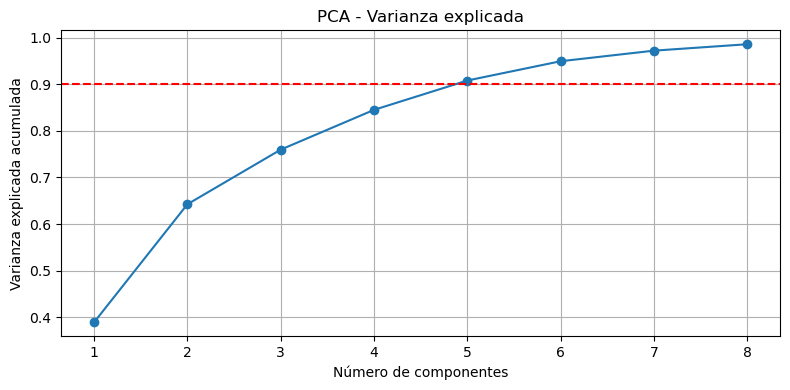

Varianza explicada acumulada:
[0.38939187 0.64253686 0.75966672 0.84497567 0.90789947 0.94924588
 0.97192818 0.98566964]


In [1465]:
plt.figure(figsize=(8, 4))
plt.plot(componentes, cumulative_var, marker='o')
plt.xticks(componentes)
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('PCA - Varianza explicada')
plt.grid(True)
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.tight_layout()
plt.show()

print(f'Varianza explicada acumulada:\n{cumulative_var}')